# Leser inn og undersøker dataene

For å forstå dataene, ønsker vi å undersøke spesifikke aspekter ved dem. Vi vil se på relativ frekvens av faktorer innad i de ulike gruppene og sammenligne resultatene. Tilfellene vi skal se på er 
* hvor ofte ulike grupperinger av mennesker(kvinner, menn, hvite og svarte) gjentar forbrytelser og blir predikert å begå straffbare handlinger i framtiden (som andel, ikke totalt antall).

* hvor ofte ulike grupper fikk ulike risikoskårer.

* hvor ofte de som begikk nye straffbare hadlinger (og de som ikke gjorde det) fikk ulike risikoskårer, og hvordan dette ser ut hvis du kun ser på hvite eller svarte.

Først importerer vi nødvendige pakker. `pandas`brukes i stor grad ettersom vi behandler dataene som "DataFrames".

In [242]:
import pandas as pd
import matplotlib.pyplot as plt

Vi leser inn dataen. Vi kvitter oss med den dataen hvor siktelsesdatoen er mer enn 30 dager unna datoen for arrestasjonen - ProPublica anså denne dataen som for usikker til å inkludere i studien.

In [265]:
data = pd.read_csv("..//Data/compas-scores-two-years.csv")
data = data[data["days_b_screening_arrest"] <= 30]
data = data[data["days_b_screening_arrest"] >= -30]

Vi lager en ny `pandas.DataFrame` og inkluderer den dataen som vi ønsker å se nærmere på. Som ProPublica, definerer vi at de som har fått COMPAS-score "Medium" eller "High" predikeres til å residivere innen to år.

In [266]:
df = pd.DataFrame({
    "kvinne": data.sex == "Female",
    "hvit": data.race == "Caucasian",
    "svart": data.race == "African-American",
    "tilbakefall": data.two_year_recid == 1,
    "predikert_tilbakefall": data.score_text != "Low",
    "lav_score": data.score_text == "Low",
    "medium_score": data.score_text == "Medium",
    "høy_score": data.score_text == "High",})

For å regne ut den relative frekvensen av forekomst av en spesifikk egenskap innad i en gruppe, brukes `prosentandel`. Funksjonen `barplott` tar inn de egenskapene og gruppene vi ønsker å undersøke og plotter resultatene i tabell og barplott.

In [279]:
def prosentandel(fokus, gruppe):
    """Regner ut prosentandelen av gruppen (gruppe) som har den spesifikke egenskapen (fokus)
    """
    return float(f'{len(df[fokus & gruppe]) / len(df[gruppe]) * 100:.1f}')

def barplott(fokusliste, gruppeliste, kol_navn, rad_navn, tittel, ha_tabell = 'Ja'):
    """Lager en DataFrame med ønskede prosentandeler og plotter den i et barplott.
    Tar inn lister over egenskaper og grupper man ønsker å undersøke, samt navn som blir synlig i tabell og plott
    """
    tabell = pd.DataFrame(columns=kol_navn)
    
    for i,fokus in enumerate(fokusliste):
        tabell.loc[i] = [prosentandel(fokus, gruppe) for gruppe in gruppeliste]
    tabell.index = rad_navn
    ax = tabell.plot.bar(colormap='Set3', figsize=(8,6), rot=0)
    ax.set_ylabel('Prosentandel')
    ax.set_title(tittel)
    plt.rcParams.update({'font.size': 13})
    if ha_tabell == 'Ja': # default er å vise tabellen i tillegg til barplottet
        display(tabell)         

Nå er vi rustet får å se på de ulike aspektene:


### Hvor ofte gjentar ulike grupperinger av mennesker (kvinner, menn, hvite og svarte) forbrytelser og blir predikert å begå straffbare handlinger i framtiden?

,Kvinner,Menn,Hvite,Svarte
Tilbakefallende,35.1,47.9,39.1,52.3
Predikert tilbakefallende,40.5,45.5,33.1,57.6


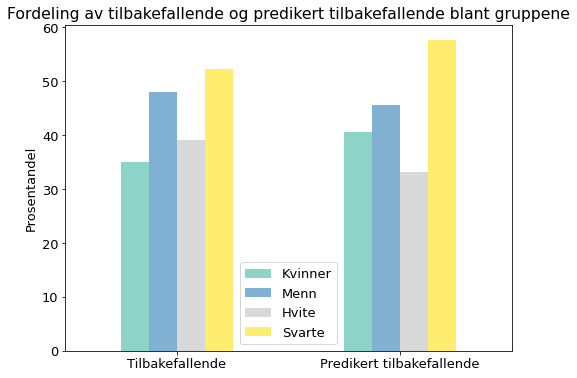

In [272]:
resid_predresid = [df.tilbakefall, df.predikert_tilbakefall]
gruppe = [df.kvinne, ~df.kvinne, df.hvit, df.svart]
gruppenavn = ['Kvinner', 'Menn', 'Hvite', 'Svarte']
resid_predresid_navn = ['Tilbakefallende', 'Predikert tilbakefallende']
tittel1 = 'Fordeling av tilbakefallende og predikert tilbakefallende blant gruppene'
barplott(resid_predresid, gruppe, gruppenavn, resid_predresid_navn, tittel1)

Vi ser at COMPAS-algoritmen predikerer en større andel svarte og kvinner til å residivere enn dét som faktisk er tilfelle, mens den vipper i motsatt retning for menn og hvite.


### Hvor ofte fikk de ulike gruppene de tre risikoskårene?


,Kvinner,Menn,Hvite,Svarte
Lav score,59.5,54.5,66.9,42.4
Medium score,27.7,25.7,22.5,31.0
Høy score,12.9,19.9,10.6,26.6


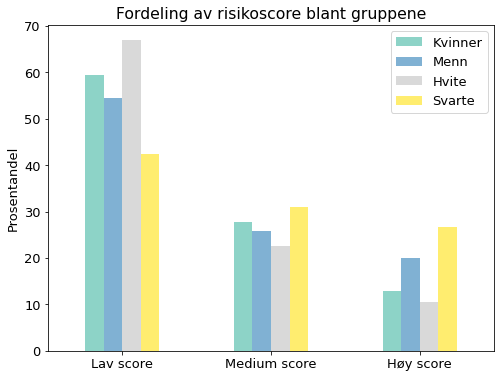

In [274]:
score = [df.lav_score, df.medium_score, df.høy_score]
score_navn = ['Lav score', 'Medium score', 'Høy score']
tittel2 = 'Fordeling av risikoscore blant gruppene'

barplott(score, gruppe, gruppenavn, score_navn, tittel2)

Det mest fremtredende resultatet her, er at hvite har tydelig lavere score enn svarte. Hvite har en overveiende prosentandel som har lav score, mens de svartes score er mer jevt fordelt.


### Hvor ofte fikk tilbakefallende og ikke-tilbakefallende ulike risikoskårer, og hvordan ser ut når vi kun ser på hvite og svarte?

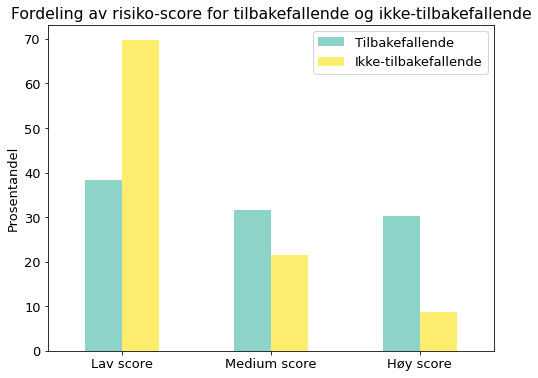

In [281]:
resid = [df.tilbakefall, ~df.tilbakefall]
resid_navn = ['Tilbakefallende', 'Ikke-tilbakefallende']
tittel3 = 'Fordeling av risiko-score for tilbakefallende og ikke-tilbakefallende'

barplott(score, resid, resid_navn, score_navn, tittel3, ha_tabell = 'Nei')

Totalt sett er COMPAS-algoritmen tydelig bedre på å predikere de som ikke tilbakefaller enn de som tilbakefaller.

,Tilbakefallende hvite,Tilbakefallende svarte,Ikke-tilbakefallende hvite,Ikke-tilbakefallende svarte
Lav score,49.6,28.5,78.0,57.7
Medium score,30.7,33.4,17.3,28.4
Høy score,19.7,38.2,4.8,13.9


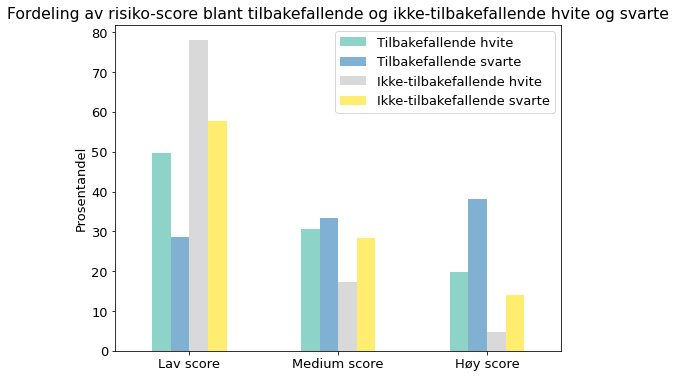

In [276]:
etnisk_resid = [df.hvit & df.tilbakefall, df.svart & df.tilbakefall, df.hvit & ~df.tilbakefall, df.svart & ~df.tilbakefall]
score_navn = ['Lav score', 'Medium score', 'Høy score']
etnisk_resid_navn = ["Tilbakefallende hvite", "Tilbakefallende svarte","Ikke-tilbakefallende hvite","Ikke-tilbakefallende svarte"]
tittel4 = 'Fordeling av risiko-score blant tilbakefallende og ikke-tilbakefallende hvite og svarte'

barplott(score, etnisk_resid, etnisk_resid_navn, score_navn, tittel4)

COMPAS-scoren gjenspeiler ikke-tilbakefallende hvite godt og ikke-tilbakefallende svarte nogenlunde. For tilbakefallende svarte er den såvidt bedre enn en random-algoritme, og for tilbakefallende hvite predikerer den dårligere enn en random-algoritme.